#Movie Recommender System

###Installing and Loading libraries

In [1]:
install.packages('recommenderlab')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘float’, ‘RcppProgress’, ‘arules’, ‘proxy’, ‘registry’, ‘irlba’, ‘recosystem’




In [2]:
library(recommenderlab)

Loading required package: Matrix

Loading required package: arules


Attaching package: ‘arules’


The following objects are masked from ‘package:base’:

    abbreviate, write


Loading required package: proxy


Attaching package: ‘proxy’


The following object is masked from ‘package:Matrix’:

    as.matrix


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


Loading required package: registry

Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy



In [4]:
install.packages('reshape2')
library(ggplot2)                      
library(data.table)
library(reshape2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’



Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt




###Retrieving the data

In [6]:
movie_data <- read.csv("movies.csv",stringsAsFactors=FALSE)
rating_data <- read.csv("ratings.csv")
str(movie_data)

'data.frame':	10329 obs. of  3 variables:
 $ movieId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ title  : chr  "Toy Story (1995)" "Jumanji (1995)" "Grumpier Old Men (1995)" "Waiting to Exhale (1995)" ...
 $ genres : chr  "Adventure|Animation|Children|Comedy|Fantasy" "Adventure|Children|Fantasy" "Comedy|Romance" "Comedy|Drama|Romance" ...


In [7]:
summary(movie_data)

    movieId          title              genres         
 Min.   :     1   Length:10329       Length:10329      
 1st Qu.:  3240   Class :character   Class :character  
 Median :  7088   Mode  :character   Mode  :character  
 Mean   : 31924                                        
 3rd Qu.: 59900                                        
 Max.   :149532                                        

In [8]:
head(movie_data)

,movieId,title,genres
,<int>,<chr>,<chr>
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,2,Jumanji (1995),Adventure|Children|Fantasy
3,3,Grumpier Old Men (1995),Comedy|Romance
4,4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,5,Father of the Bride Part II (1995),Comedy
6,6,Heat (1995),Action|Crime|Thriller


In [9]:
head(rating_data)

,userId,movieId,rating,timestamp
,<int>,<int>,<dbl>,<int>
1,1,16,4.0,1217897793
2,1,24,1.5,1217895807
3,1,32,4.0,1217896246
4,1,47,4.0,1217896556
5,1,50,4.0,1217896523
6,1,110,4.0,1217896150


###Data Pre-processing

We need to convert the genres present in the movie_data dataframe into a more usable format by the users. In order to do so, we will first create a one-hot encoding to create a matrix that comprises of corresponding genres for each of the films.

In [10]:
movie_genre <- as.data.frame(movie_data$genres, stringsAsFactors=FALSE)
library(data.table)
movie_genre2 <- as.data.frame(tstrsplit(movie_genre[,1], '[|]', 
                                   type.convert=TRUE), 
                         stringsAsFactors=FALSE) 
colnames(movie_genre2) <- c(1:10)

list_genre <- c("Action", "Adventure", "Animation", "Children", 
                "Comedy", "Crime","Documentary", "Drama", "Fantasy",
                "Film-Noir", "Horror", "Musical", "Mystery","Romance",
                "Sci-Fi", "Thriller", "War", "Western")
genre_mat1 <- matrix(0,10330,18)
genre_mat1[1,] <- list_genre
colnames(genre_mat1) <- list_genre

for (index in 1:nrow(movie_genre2)) {
  for (col in 1:ncol(movie_genre2)) {
    gen_col = which(genre_mat1[1,] == movie_genre2[index,col]) 
    genre_mat1[index+1,gen_col] <- 1
}
}
genre_mat2 <- as.data.frame(genre_mat1[-1,], stringsAsFactors=FALSE) #remove first row, which was the genre list
for (col in 1:ncol(genre_mat2)) {
  genre_mat2[,col] <- as.integer(genre_mat2[,col]) #convert from characters to integers
} 
str(genre_mat2)

'data.frame':	10329 obs. of  18 variables:
 $ Action     : int  0 0 0 0 0 1 0 0 1 1 ...
 $ Adventure  : int  1 1 0 0 0 0 0 1 0 1 ...
 $ Animation  : int  1 0 0 0 0 0 0 0 0 0 ...
 $ Children   : int  1 1 0 0 0 0 0 1 0 0 ...
 $ Comedy     : int  1 0 1 1 1 0 1 0 0 0 ...
 $ Crime      : int  0 0 0 0 0 1 0 0 0 0 ...
 $ Documentary: int  0 0 0 0 0 0 0 0 0 0 ...
 $ Drama      : int  0 0 0 1 0 0 0 0 0 0 ...
 $ Fantasy    : int  1 1 0 0 0 0 0 0 0 0 ...
 $ Film-Noir  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Horror     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Musical    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Mystery    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Romance    : int  0 0 1 1 0 0 1 0 0 0 ...
 $ Sci-Fi     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Thriller   : int  0 0 0 0 0 1 0 0 0 1 ...
 $ War        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Western    : int  0 0 0 0 0 0 0 0 0 0 ...


We will create a 'search matrix' that will allow us to perform an easy search of the films by specifying the genre in our list

In [11]:
SearchMatrix <- cbind(movie_data[,1:2], genre_mat2[])
head(SearchMatrix)    

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,Toy Story (1995),0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2,Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
5,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,6,Heat (1995),1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


We have to convert rating_data into a sparse matrix to use it in recommenderlabs.

In [12]:
ratingMatrix <- dcast(rating_data, userId~movieId, value.var = "rating", na.rm=FALSE)
ratingMatrix <- as.matrix(ratingMatrix[,-1]) #remove userIds
#Convert rating matrix into a recommenderlab sparse matrix
ratingMatrix <- as(ratingMatrix, "realRatingMatrix")
ratingMatrix

668 x 10325 rating matrix of class ‘realRatingMatrix’ with 105339 ratings.

Various options available in recommenderlab


In [13]:
recommendation_model <- recommenderRegistry$get_entries(dataType = "realRatingMatrix")
names(recommendation_model)

[1] "HYBRID_realRatingMatrix"       "ALS_realRatingMatrix"         
 [3] "ALS_implicit_realRatingMatrix" "IBCF_realRatingMatrix"        
 [5] "LIBMF_realRatingMatrix"        "POPULAR_realRatingMatrix"     
 [7] "RANDOM_realRatingMatrix"       "RERECOMMEND_realRatingMatrix" 
 [9] "SVD_realRatingMatrix"          "SVDF_realRatingMatrix"        
[11] "UBCF_realRatingMatrix"

In [14]:
lapply(recommendation_model, "[[", "description")

$HYBRID_realRatingMatrix
[1] "Hybrid recommender that aggegates several recommendation strategies using weighted averages."

$ALS_realRatingMatrix
[1] "Recommender for explicit ratings based on latent factors, calculated by alternating least squares algorithm."

$ALS_implicit_realRatingMatrix
[1] "Recommender for implicit data based on latent factors, calculated by alternating least squares algorithm."

$IBCF_realRatingMatrix
[1] "Recommender based on item-based collaborative filtering."

$LIBMF_realRatingMatrix
[1] "Matrix factorization with LIBMF via package recosystem (https://cran.r-project.org/web/packages/recosystem/vignettes/introduction.html)."

$POPULAR_realRatingMatrix
[1] "Recommender based on item popularity."

$RANDOM_realRatingMatrix
[1] "Produce random recommendations (real ratings)."

$RERECOMMEND_realRatingMatrix
[1] "Re-recommends highly rated items (real ratings)."

$SVD_realRatingMatrix
[1] "Recommender based on SVD approximation with column-mean imputation."

$SVDF_realRatingMatrix
[1] "Recommender based on Funk SVD with gradient descend (https://sifter.org/~simon/journal/20061211.html)."

$UBCF_realRatingMatrix
[1] "Recommender based on user-based collaborative filtering."

We will implement a single model which is 'Item Based Collaborative Filtering'

In [15]:
recommendation_model$IBCF_realRatingMatrix$parameters

$k
[1] 30

$method
[1] "Cosine"

$normalize
[1] "center"

$normalize_sim_matrix
[1] FALSE

$alpha
[1] 0.5

$na_as_zero
[1] FALSE

###Exploring Similar Data

Collaborative Filtering involves suggesting movies to the users that are based on collecting preferences from many other users. For example, if a user A likes to watch action films and so does user B, then the movies that the user B will watch in the future will be recommended to A and vice-versa. Therefore, recommending movies is dependent on creating a relationship of similarity between the two users. With the help of recommenderlab, we can compute similarities using various operators like cosine, pearson as well as jaccard.

,1,2,3,4
1,0.0000000,0.9760860,0.9641723,0.9914398
2,0.9760860,0.0000000,0.9925732,0.9374253
3,0.9641723,0.9925732,0.0000000,0.9888968
4,0.9914398,0.9374253,0.9888968,0.0000000


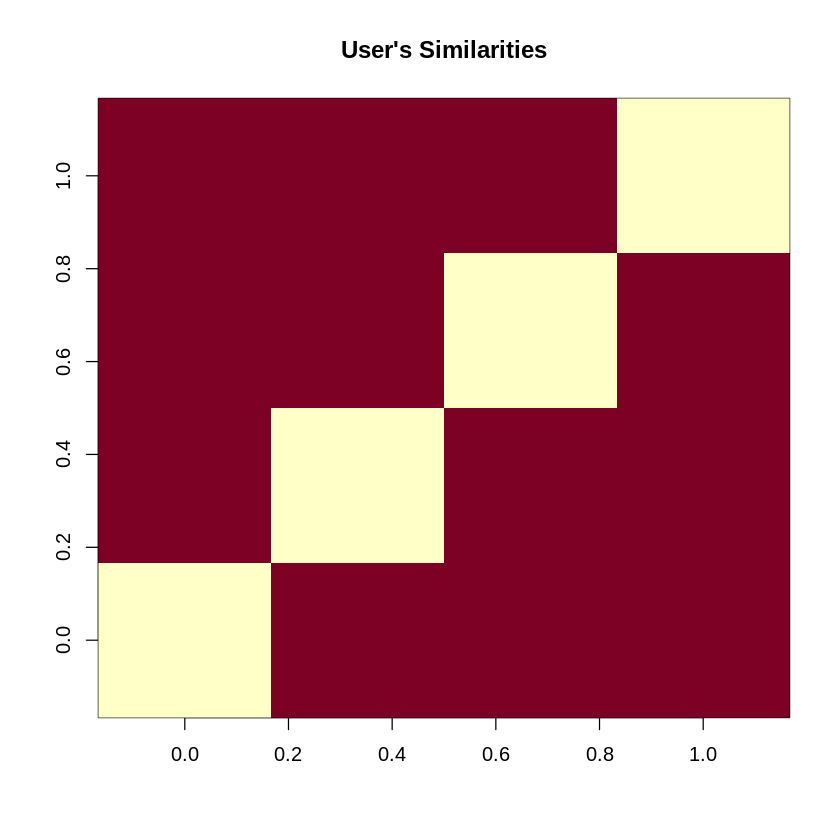

In [16]:
similarity_mat <- similarity(ratingMatrix[1:4, ],
                               method = "cosine",
                               which = "users")
as.matrix(similarity_mat)

image(as.matrix(similarity_mat), main = "User's Similarities")

,1,2,3,4
1,0.0000000,0.9669732,0.9559341,0.9101276
2,0.9669732,0.0000000,0.9658757,0.9412416
3,0.9559341,0.9658757,0.0000000,0.9864877
4,0.9101276,0.9412416,0.9864877,0.0000000


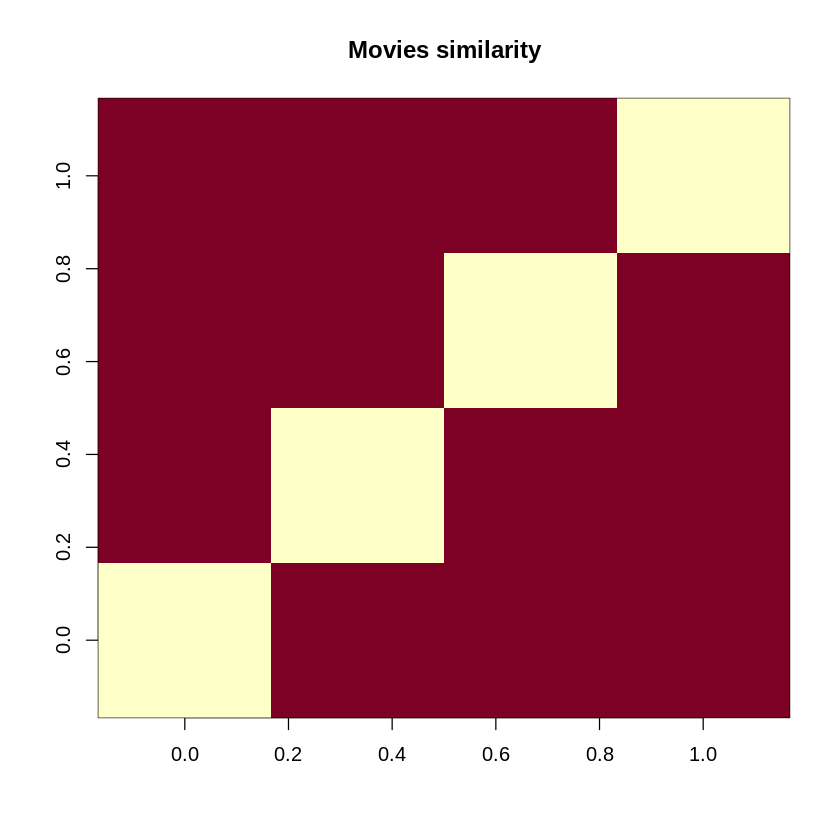

In [17]:
movie_similarity <- similarity(ratingMatrix[, 1:4], method =
                                 "cosine", which = "items")
as.matrix(movie_similarity)

image(as.matrix(movie_similarity), main = "Movies similarity")

In [18]:
rating_values <- as.vector(ratingMatrix@data)
unique(rating_values) # extracting unique ratings

[1] 0.0 5.0 4.0 3.0 4.5 1.5 2.0 3.5 1.0 2.5 0.5

In [20]:
Table_of_Ratings <- table(rating_values) # creating a count of movie ratings
Table_of_Ratings

rating_values
      0     0.5       1     1.5       2     2.5       3     3.5       4     4.5 
6791761    1198    3258    1567    7943    5484   21729   12237   28880    8187 
      5 
  14856 

In [21]:
library(ggplot2)
movie_views <- colCounts(ratingMatrix) # count views for each movie
table_views <- data.frame(movie = names(movie_views),
                          views = movie_views) # create dataframe of views
table_views <- table_views[order(table_views$views,
                                 decreasing = TRUE), ] # sort by number of views
table_views$title <- NA
for (index in 1:10325){
  table_views[index,3] <- as.character(subset(movie_data,
                                         movie_data$movieId == table_views[index,1])$title)
}
table_views[1:6,]

,movie,views,title
,<chr>,<int>,<chr>
296,296,325,Pulp Fiction (1994)
356,356,311,Forrest Gump (1994)
318,318,308,"Shawshank Redemption, The (1994)"
480,480,294,Jurassic Park (1993)
593,593,290,"Silence of the Lambs, The (1991)"
260,260,273,Star Wars: Episode IV - A New Hope (1977)


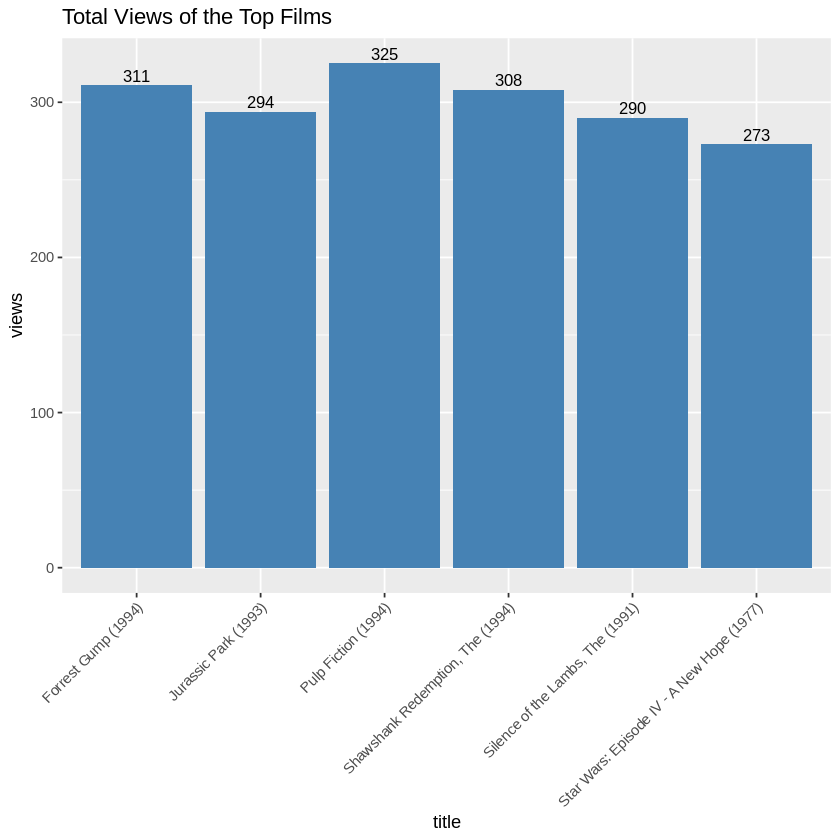

In [22]:
ggplot(table_views[1:6, ], aes(x = title, y = views)) +
  geom_bar(stat="identity", fill = 'steelblue') +
  geom_text(aes(label=views), vjust=-0.3, size=3.5) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +

  ggtitle("Total Views of the Top Films")

###Heatmap of Movie Ratings

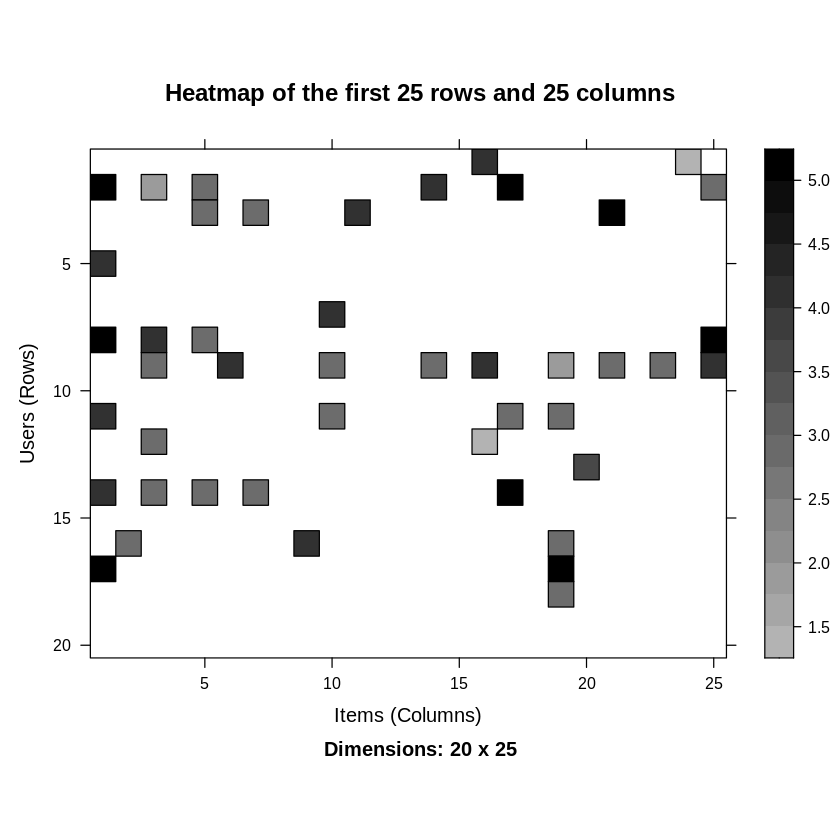

In [23]:
image(ratingMatrix[1:20, 1:25], axes = FALSE, main = "Heatmap of the first 25 rows and 25 columns")

###Performing Data Preparation

We will conduct data preparation in the following three steps –

1.   Selecting useful data
2.   Normalizing data
3.   Binarizing the data

For finding useful data in our dataset, we have set the threshold for the minimum number of users who have rated a film as 50. This is also same for minimum number of views that are per film. This way, we have filtered a list of watched films from least-watched ones.

In [25]:
movie_ratings <- ratingMatrix[rowCounts(ratingMatrix) > 50,
                             colCounts(ratingMatrix) > 50]
movie_ratings

420 x 447 rating matrix of class ‘realRatingMatrix’ with 38341 ratings.

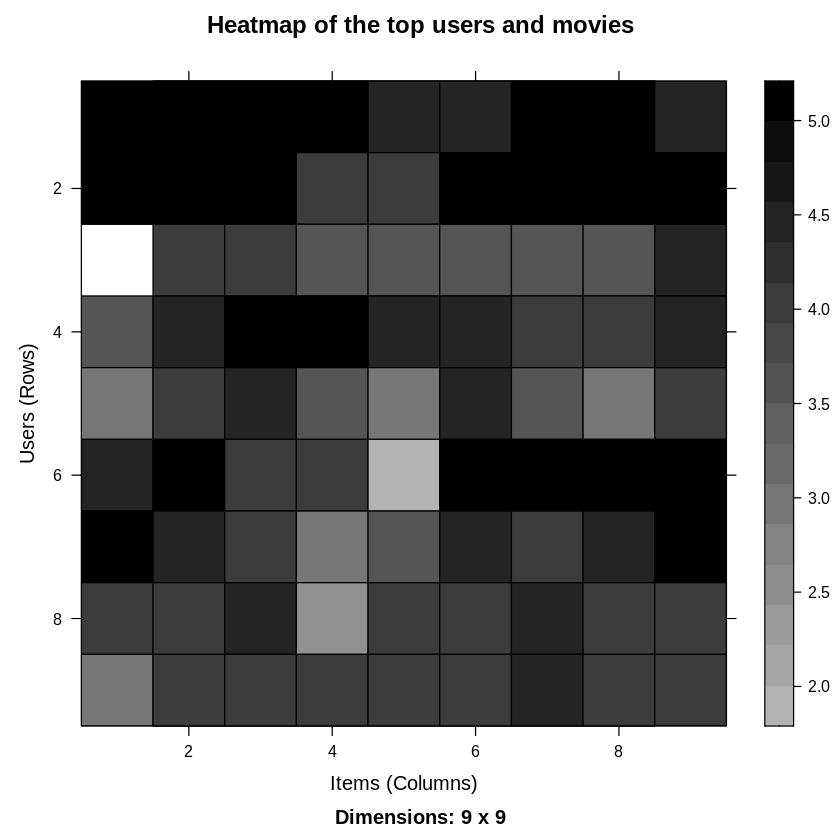

In [26]:
minimum_movies<- quantile(rowCounts(movie_ratings), 0.98)
minimum_users <- quantile(colCounts(movie_ratings), 0.98)
image(movie_ratings[rowCounts(movie_ratings) > minimum_movies,
                     colCounts(movie_ratings) > minimum_users],
main = "Heatmap of the top users and movies")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



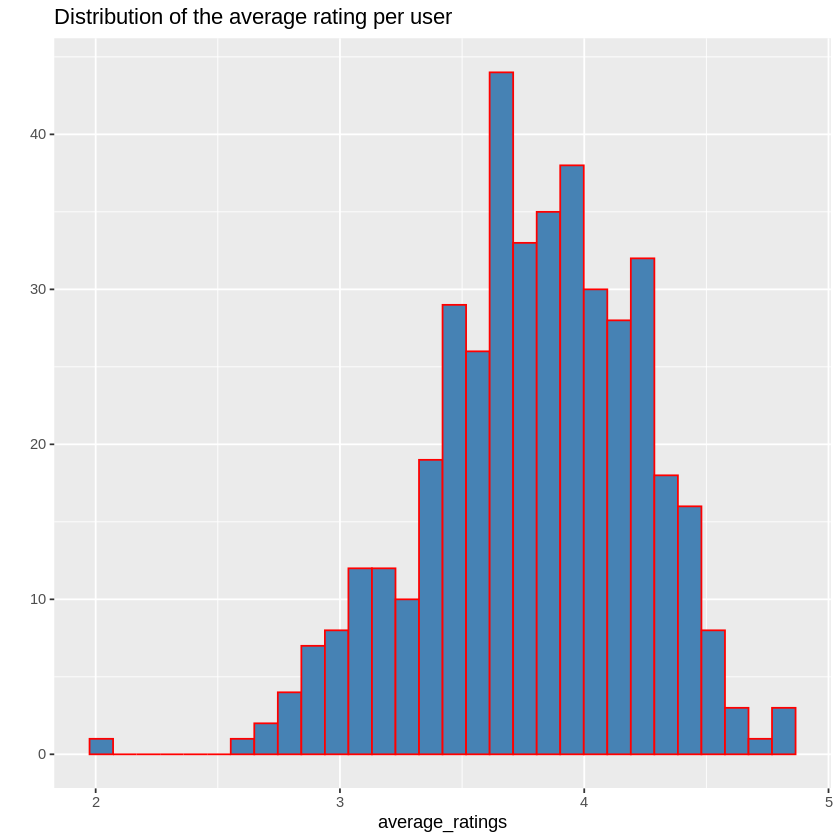

In [27]:
average_ratings <- rowMeans(movie_ratings)
qplot(average_ratings, fill=I("steelblue"), col=I("red")) +
  ggtitle("Distribution of the average rating per user")

Data Normalization

In the case of some users, there can be high ratings or low ratings provided to all of the watched films. This will act as a bias while implementing our model. In order to remove this, we normalize our data.

[1] 0

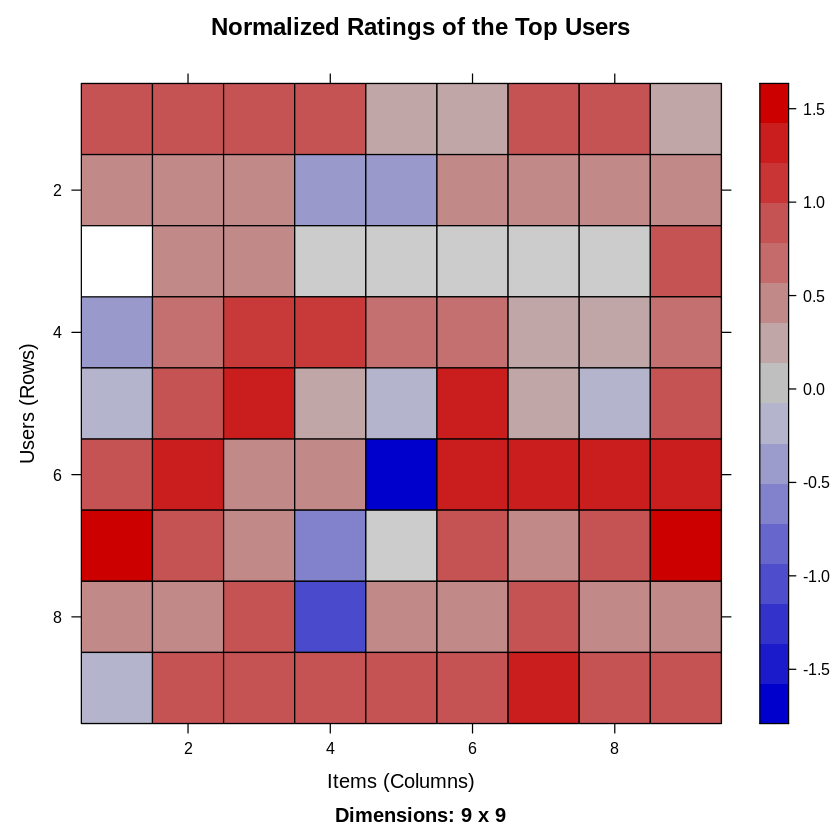

In [28]:
normalized_ratings <- normalize(movie_ratings)
sum(rowMeans(normalized_ratings) > 0.00001)

image(normalized_ratings[rowCounts(normalized_ratings) > minimum_movies,
                          colCounts(normalized_ratings) > minimum_users],
main = "Normalized Ratings of the Top Users")

Performing Data Binarization

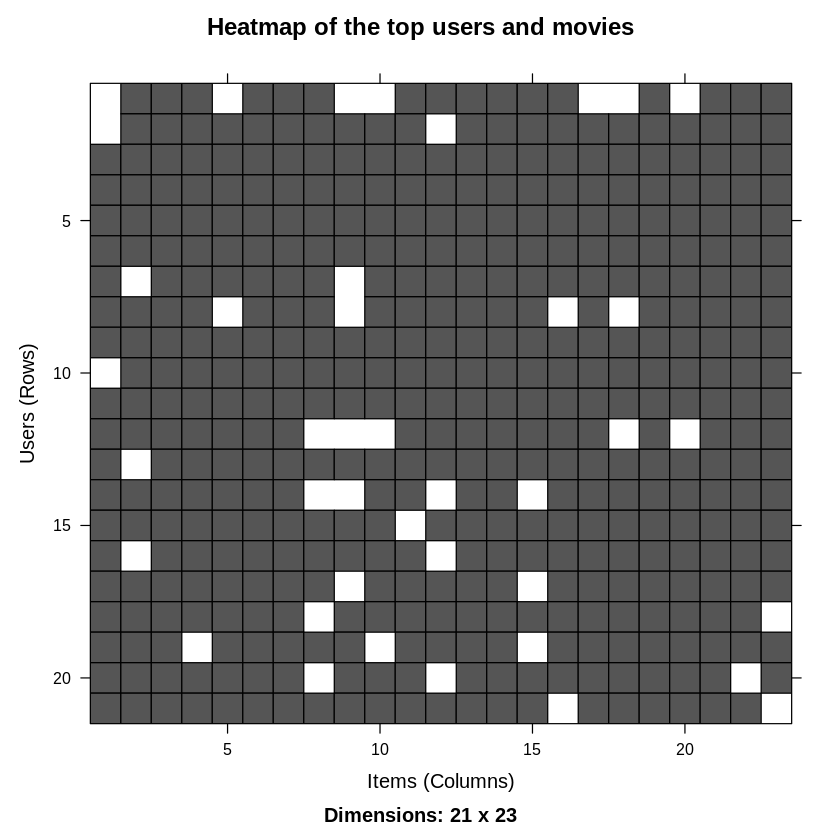

In [29]:
binary_minimum_movies <- quantile(rowCounts(movie_ratings), 0.95)
binary_minimum_users <- quantile(colCounts(movie_ratings), 0.95)
#movies_watched <- binarize(movie_ratings, minRating = 1)

good_rated_films <- binarize(movie_ratings, minRating = 3)
image(good_rated_films[rowCounts(movie_ratings) > binary_minimum_movies,
colCounts(movie_ratings) > binary_minimum_users],
main = "Heatmap of the top users and movies")

###Collabortive Filtering System

In [30]:
sampled_data<- sample(x = c(TRUE, FALSE),
                      size = nrow(movie_ratings),
                      replace = TRUE,
                      prob = c(0.8, 0.2))
training_data <- movie_ratings[sampled_data, ]
testing_data <- movie_ratings[!sampled_data, ]

In [31]:
recommendation_system <- recommenderRegistry$get_entries(dataType ="realRatingMatrix")
recommendation_system$IBCF_realRatingMatrix$parameters

$k
[1] 30

$method
[1] "Cosine"

$normalize
[1] "center"

$normalize_sim_matrix
[1] FALSE

$alpha
[1] 0.5

$na_as_zero
[1] FALSE

In [32]:
recommen_model <- Recommender(data = training_data,
                          method = "IBCF",
                          parameter = list(k = 30))
recommen_model
class(recommen_model)

Recommender of type ‘IBCF’ for ‘realRatingMatrix’ 
learned using 332 users.

[1] "Recommender"
attr(,"package")
[1] "recommenderlab"

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

[1] 447 447

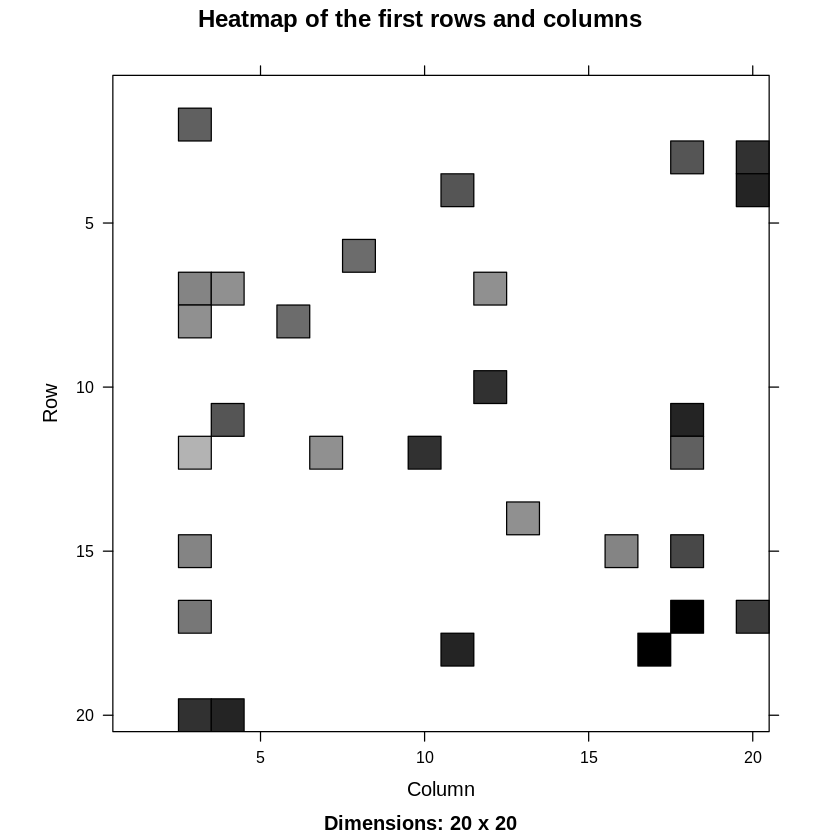

In [33]:
model_info <- getModel(recommen_model)
class(model_info$sim)
dim(model_info$sim)
top_items <- 20
image(model_info$sim[1:top_items, 1:top_items],
   main = "Heatmap of the first rows and columns")

sum_rows
 30 
447 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



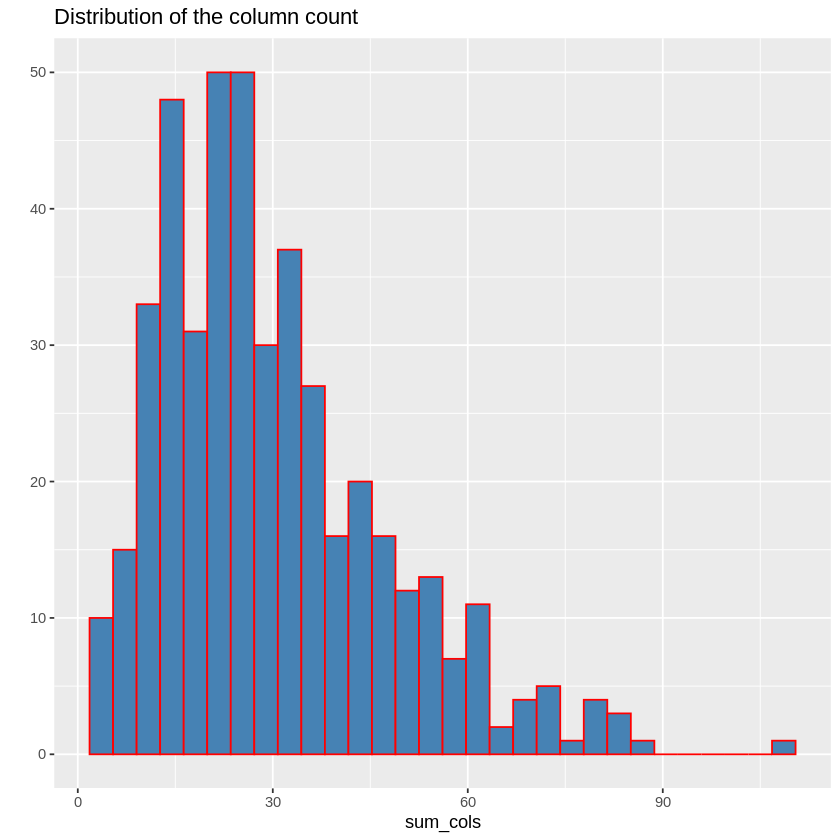

In [34]:
sum_rows <- rowSums(model_info$sim > 0)
table(sum_rows)

sum_cols <- colSums(model_info$sim > 0)
qplot(sum_cols, fill=I("steelblue"), col=I("red"))+ ggtitle("Distribution of the column count")

###Building Recommender System

In [35]:
top_recommendations <- 10 # the number of items to recommend to each user
predicted_recommendations <- predict(object = recommen_model,
                          newdata = testing_data,
                          n = top_recommendations)
predicted_recommendations

Recommendations as ‘topNList’ with n = 10 for 88 users. 

In [36]:
user1 <- predicted_recommendations@items[[1]] # recommendation for the first user
movies_user1 <- predicted_recommendations@itemLabels[user1]
movies_user2 <- movies_user1
for (index in 1:10){
  movies_user2[index] <- as.character(subset(movie_data,
                                         movie_data$movieId == movies_user1[index])$title)
}
movies_user2

[1] "Casino (1995)"                                             
 [2] "Twelve Monkeys (a.k.a. 12 Monkeys) (1995)"                 
 [3] "Taxi Driver (1976)"                                        
 [4] "Like Water for Chocolate (Como agua para chocolate) (1992)"
 [5] "Blade Runner (1982)"                                       
 [6] "Trainspotting (1996)"                                      
 [7] "Vertigo (1958)"                                            
 [8] "North by Northwest (1959)"                                 
 [9] "Casablanca (1942)"                                         
[10] "2001: A Space Odyssey (1968)"

In [37]:
recommendation_matrix <- sapply(predicted_recommendations@items,
                      function(x){ as.integer(colnames(movie_ratings)[x]) }) # matrix with the recommendations for each user
#dim(recc_matrix)
recommendation_matrix[,1:4]

16,594,3039,1148
32,1097,48516,48780
111,1479,70286,555
265,1961,924,8961
541,60069,5060,4973
778,50,3147,79132
903,3147,3421,2571
908,8961,288,778
912,2542,1285,1961
924,8368,48394,3114
